In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle

%matplotlib inline

In [2]:
ls

 Volume in drive D is E.S.L.A.M
 Volume Serial Number is 7F5F-0840

 Directory of D:\# C++\Udacity\Self Driving Car notebooks\Advanced-Lane-Lines\src

2021-01-28  07:41 AM    <DIR>          .
2021-01-28  07:41 AM    <DIR>          ..
2021-01-04  06:19 AM    <DIR>          .ipynb_checkpoints
2021-01-08  01:54 AM    <DIR>          __pycache__
2021-01-23  01:35 AM         1,260,291 annotatedOutput.png
2019-01-11  11:21 PM           168,715 binary_combo_example.jpg
2021-01-28  07:39 AM         8,603,770 calibration.ipynb
2021-01-06  11:15 PM               333 camera_data.p
2021-01-10  11:49 AM               333 camera_matrices.p
2021-01-04  06:31 AM         2,960,497 chess_done_Grid.png
2021-01-04  03:00 AM    <DIR>          chessOutput
2019-01-11  11:21 PM            68,063 color_fit_lines.jpg
2021-01-04  04:53 AM         3,900,613 example.ipynb
2021-01-28  04:24 AM           147,015 example_output.jpg
2021-01-23  03:49 AM        19,107,525 project_video_output.mp4
2021-01-10  03:15 PM   

## Functions for image calibration, Undistortion, warping

In [3]:
#chessboard photos calibration constants
NX, NY = (9, 6)
CALIBRATION_IMAGES_PATH = '../camera_cal/'
MARGINX_OF_OBJECT_IMAGE,  MARGINY_OF_OBJECT_IMAGE = 136, 100

In [4]:
def get_camera_matrices():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((NX*NY, 3), np.float32)
    objp[:, :2] = np.mgrid[0:NX, 0:NY].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.
    # Make a list of calibration images
    path_pattern = CALIBRATION_IMAGES_PATH+'calibration*.jpg'
#     print(path_pattern)
    images = glob.glob(path_pattern)
#     print(images)

    # Step through the list and search for chessboard corners
    img_size = tuple()
    for idx, fname in enumerate(images):
#         print(fname)
    
        curr_image = cv2.imread(fname)
        gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        img_size = (gray.shape[1], gray.shape[0])
#     print(img_size)
    # Do camera calibration given object points and image points
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_size, None, None)
    
    if ret:
        data_camera = {'mtx':mtx,'dist':dist}
        with open('camera_matrices.p','wb') as f :
            pickle.dump(data_camera,f)
        print('done')
        return mtx, dist, rvecs, tvecs
    else:
        raise("ERROR while calibration")




In [5]:
def get_chess_calibration_points(img,marginx=MARGINX_OF_OBJECT_IMAGE,marginy=MARGINY_OF_OBJECT_IMAGE,visualize=False):
    """
    returns the outer 4 corners detected in the chessboard pattern as source and destination np.array of points in the same order
    """
    img_copy = np.copy(img)
    h, w = img_copy.shape[:2]
    NX, NY = (9, 6)
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    corner_points = [(marginx-19, marginy+60), (w-marginx+96, marginy+71),
                     (marginx+110, h-marginy+23), (w-marginx-65, h-marginy+15)]
    if visualize:
        visualize_points(corner_points, img_copy)
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    dst = np.float32(corner_points)
    src = np.float32([corners[0], corners[NX-1], corners[-NY], corners[-1]])
    return src, dst

def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped


In [6]:
def undistort(img,camera_file_path='camera_matrices.p'):
    """
    undistorts the given img with the help of camera intrinsic properties
    """
    if camera_file_path not in os.listdir('.'):
        print("writing new camera file")
        mtx,dist,_,_ = get_camera_matrices(input_image) 
    else : 
        camera_file= open(camera_file_path,'rb')
        camera_matrices =pickle.load(camera_file)
        mtx,dist = camera_matrices['mtx'], camera_matrices['dist']    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

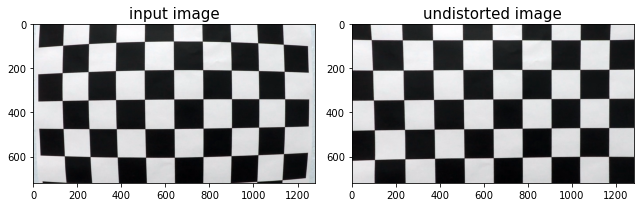

In [7]:
image_path ="../camera_cal/calibration1.jpg"
input_image = cv2.imread(image_path)
undistorted = undistort(input_image,camera_file_path='camera_matrices.p')
# src, dst = get_chess_calibration_points(udistorted,visualize=False)
# warped = warper(udistorted, src, dst)
# cv2.imshow("undistorted version of  "+image_path.split('/')[-1], udistorted)
fig , axes = plt.subplots(1,2,figsize=(9,6))
axes[0].imshow(input_image)
axes[0].set_title("input image",fontsize=15)
axes[1].imshow(undistorted)
axes[1].set_title("undistorted image",fontsize=15)
fig.tight_layout()
fig.savefig("../output_images/undistorted_chessboard")

### Chessboard corners images 
you can see some of them, the algorithm wasn't able to find any corners in them

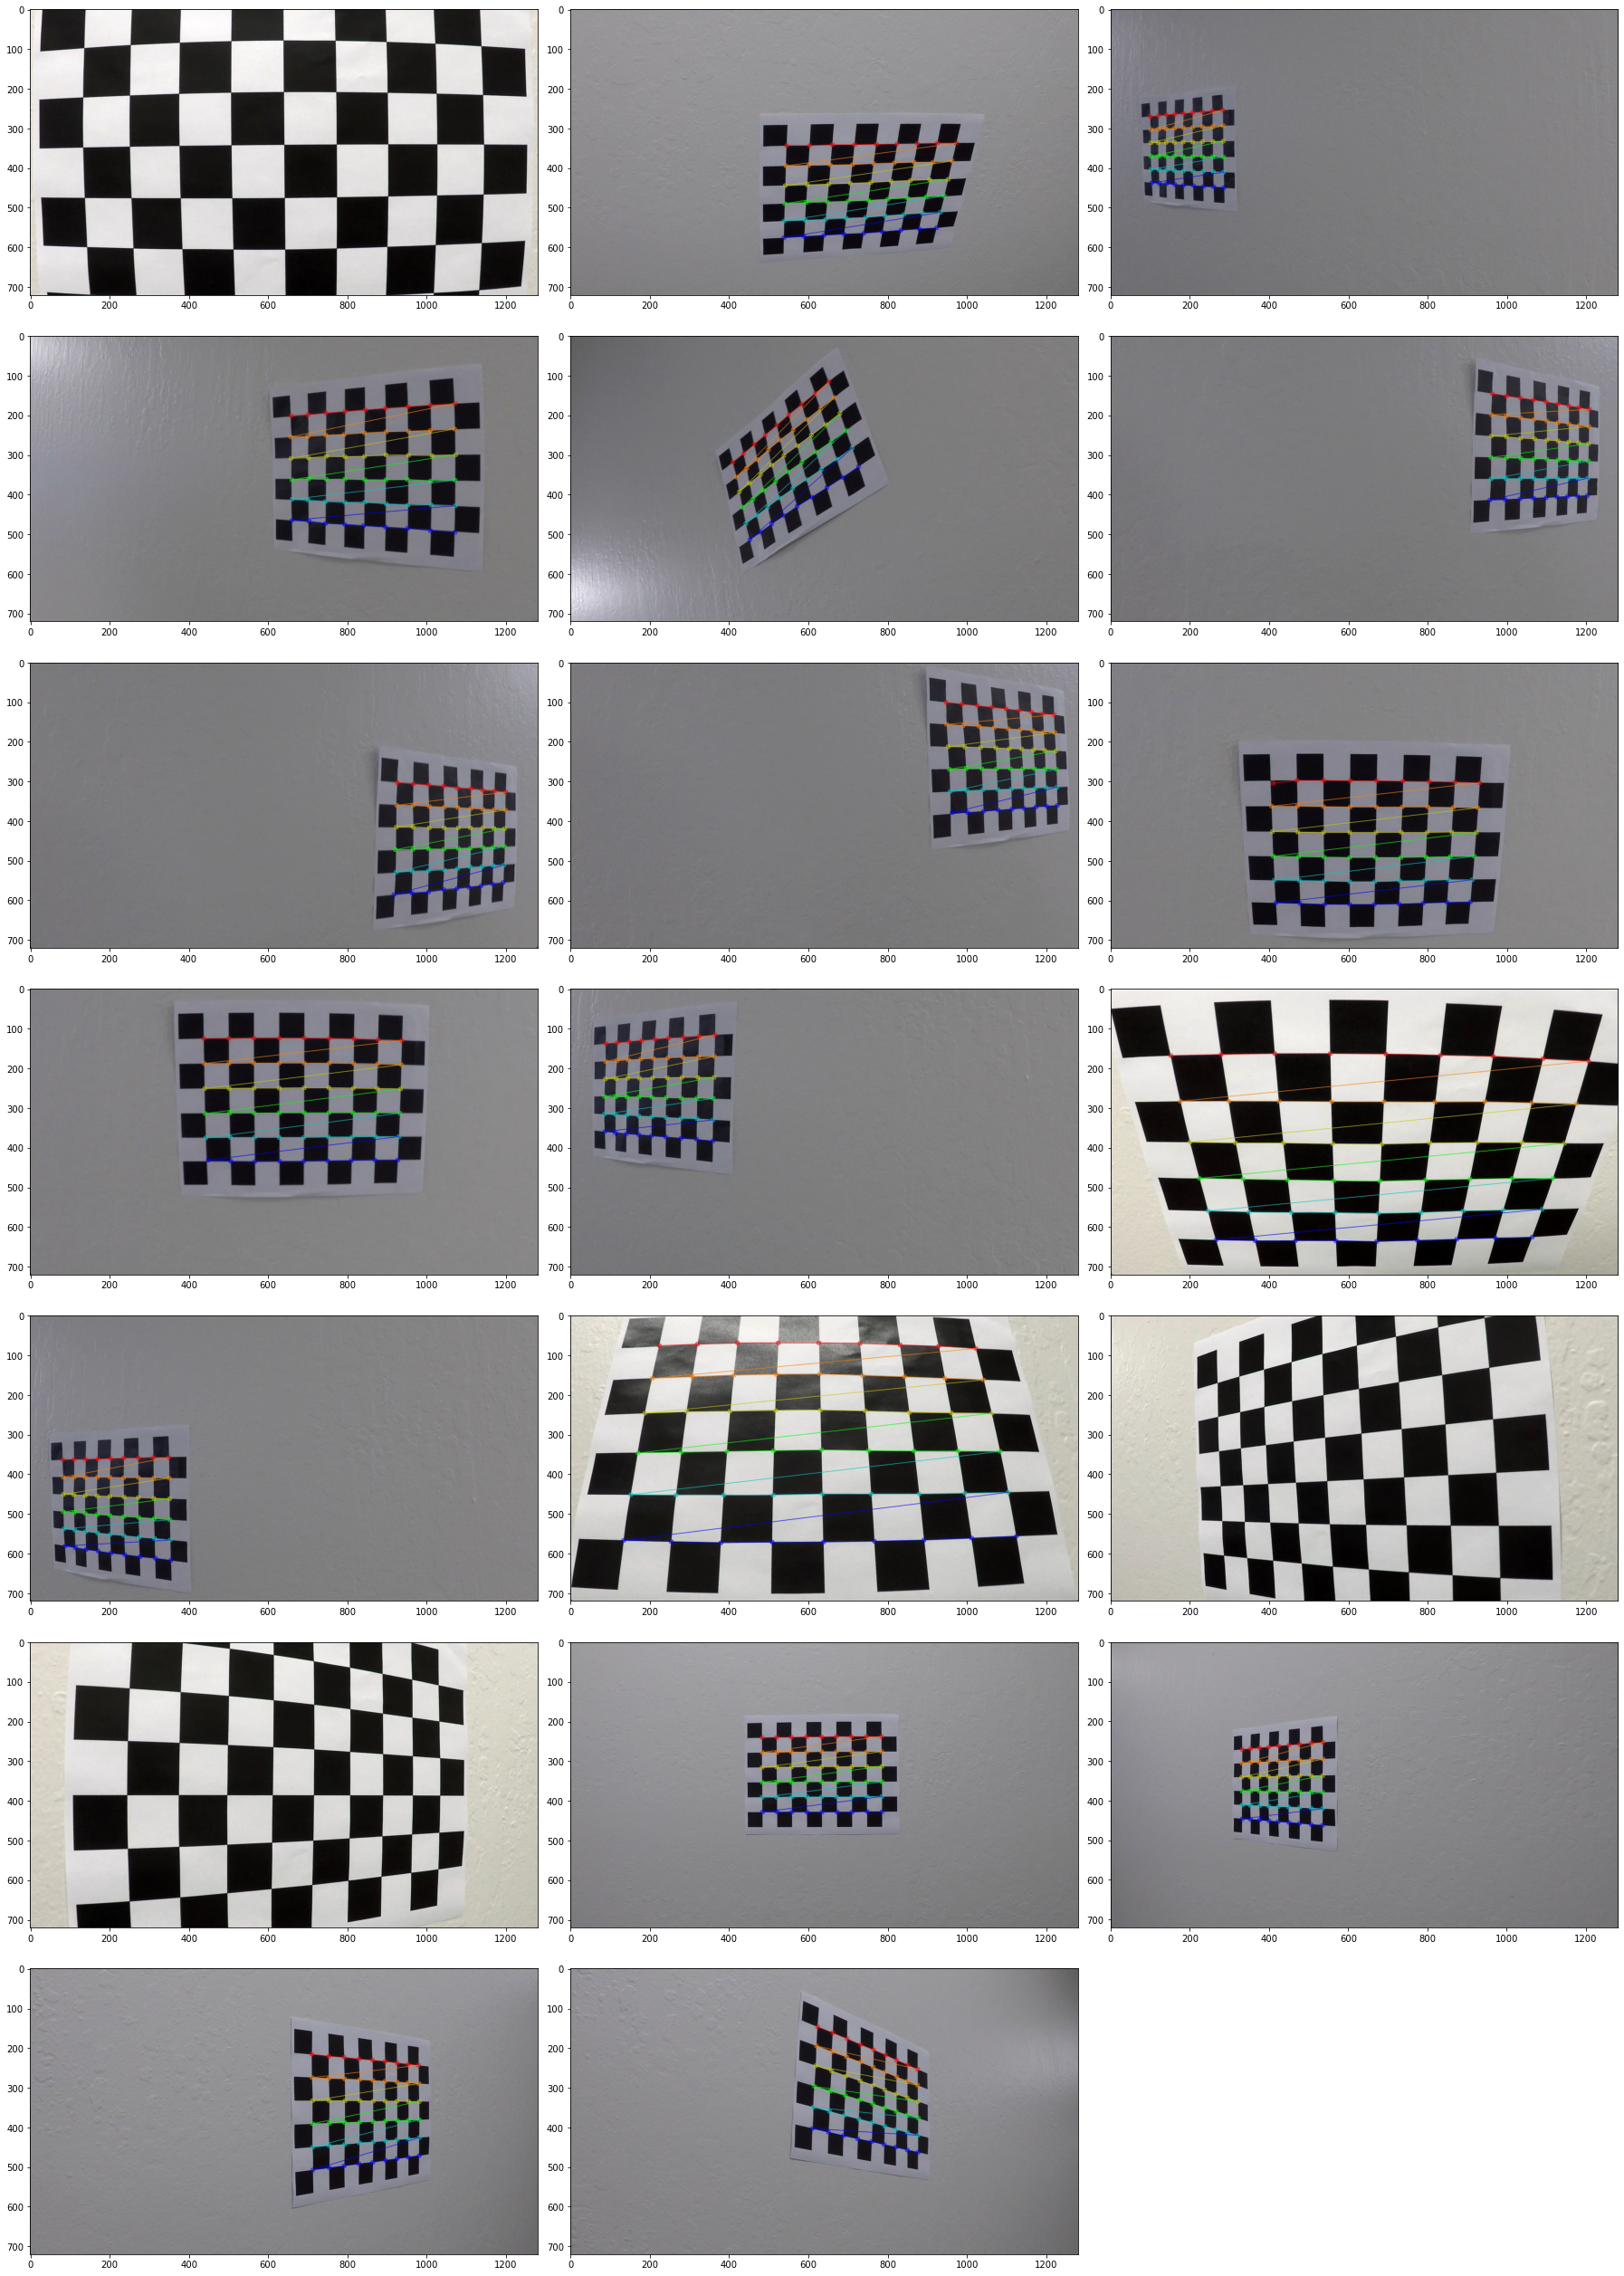

In [8]:
fig=plt.figure(figsize=(25,50))
# plt.axis('off')
# plt.tight_layout(True)
for idx,image in enumerate(os.listdir("chessOutput/")): #your current dir is the at  ---> /examples/*
    imData = mpimg.imread("chessOutput/"+image)
    fig.add_subplot(10,3,idx+1)
    plt.tight_layout(True)
    plt.imshow(imData)
    fig.savefig("../output_images/chess_done_Grid.png")

## Undistort  road images in test_images folder

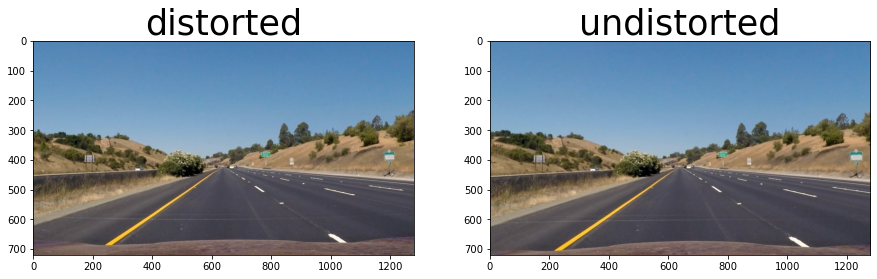

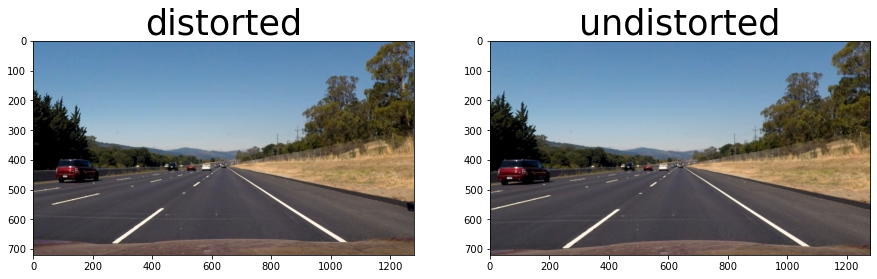

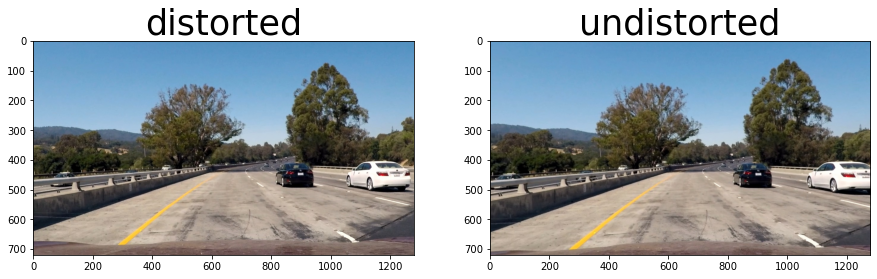

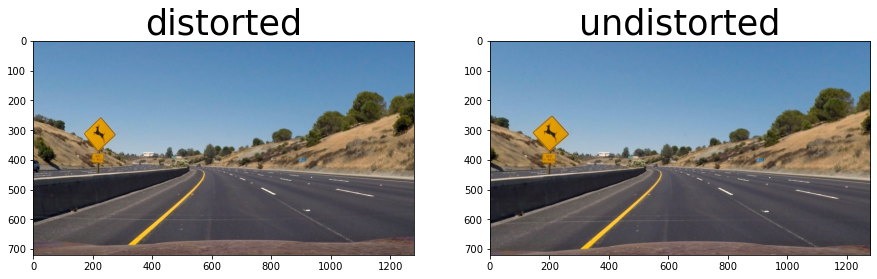

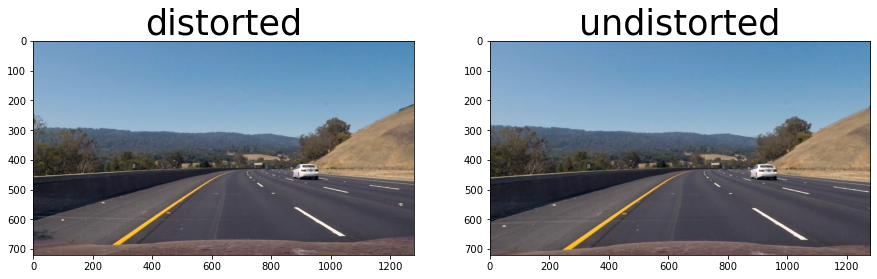

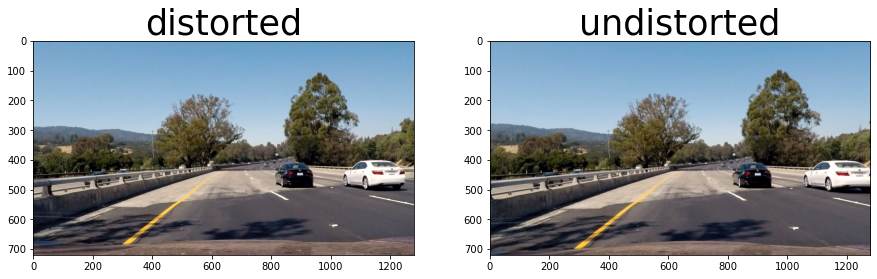

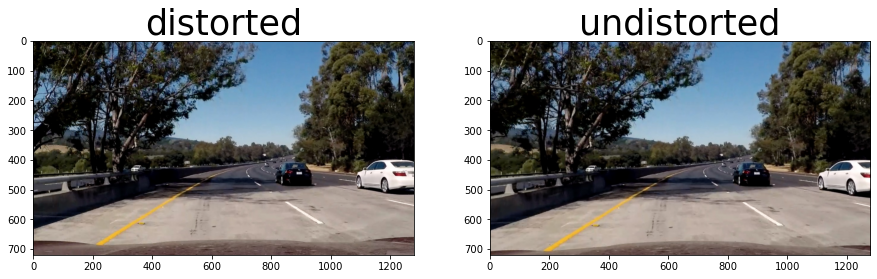

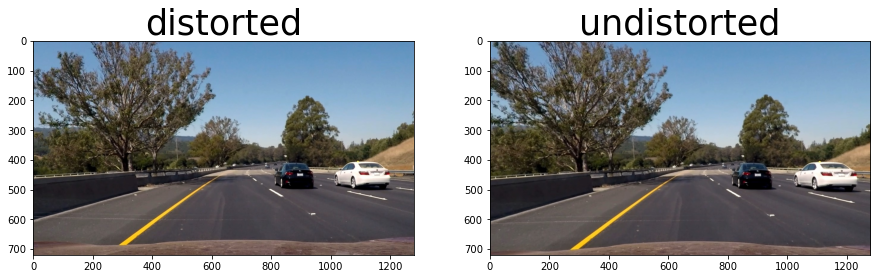

In [9]:

for idx,image_path in enumerate(os.listdir("../test_images/")):
    image_path ="../test_images/" + image_path #add root directory to file name
    input_image = cv2.imread(image_path)
    input_image =cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB) #convert to RGB
    fig,ax=plt.subplots(1,2,figsize=(15,18))
    ax[0].imshow(input_image)
    ax[0].title.set_text('distorted')
    ax[0].title.set_size(35)
    undist = undistort(input_image)
    ax[1].imshow(undist)
    ax[1].title.set_text('undistorted')
    ax[1].title.set_size(35)
    fig.savefig("../output_images/undistorted_road")

## we can do two types of thresholding:

1. **Color Thresholding (rgb,hls,hsv)**
2. **gradient thresholding (sobelx, sobely, sobel_Magnitude, sobel_Direction)**
**we can combine both of them**  

so we have a lot of thresholding combinations

In [8]:

def hls_select(img, thresh=(80, 255),selected_channel='s'):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    mask = np.zeros_like(s)
    channels = {'h':h,'l':l,'s':s}
    mask[(channels.get(selected_channel)<=thresh[1]) &( channels.get(selected_channel)>thresh[0]) ] = 1
    binary_output = np.copy(mask)
    return mask

def rgb_select(img, thresh=(80, 255),selected_channel='r'):
    bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    b = bgr[:,:,0]
    g = bgr[:,:,1]
    r = bgr[:,:,2]
    mask = np.zeros_like(r)
    channels = {'r':r,'g':g,'b':b}
    mask[(channels.get(selected_channel)<=thresh[1]) &( channels.get(selected_channel)>thresh[0]) ] = 1   
    return mask

def abs_sobel_thresh(img, orient='x',thresh=(0, 255)):
    thresh_min,thresh_max = thresh
    #Converting to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #taking the derivative in x or y given orient = 'x' or 'y'
    driv = cv2.Sobel(gray,cv2.CV_64F, 1, 0) if orient == "x" else cv2.Sobel(gray,cv2.CV_64F, 0, 1)
    # taking the absolute value of the derivative or gradient
    absolute_sobel = np.absolute(driv)
    #Scaling to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*absolute_sobel/np.max(absolute_sobel))
    #Creating a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = np.zeros_like(scaled_sobel)
  
    mask[(thresh_min<=scaled_sobel)&(scaled_sobel<=thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return mask
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    xSobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ySobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(np.absolute(xSobel)**2+np.absolute(ySobel)**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel >= thresh[0]) &
                        (scaled_sobel <= thresh[1])] =1
    return mask

def dir_threshold(img,sobel_kernel=15, thresh=(0.7, 1.3)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    xSobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ySobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_sobel = np.arctan2(np.absolute(ySobel),np.absolute(xSobel))
    # scaled_sobel = np.uint8(255*dir_sobel/np.max(dir_sobel))
    scaled_sobel = np.copy(dir_sobel)
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel >= thresh[0]) &
                        (scaled_sobel <= thresh[1])] =1
    return mask


In [9]:
IMAGE_PATH = '../test_images/test5.jpg'
TARGET_IMAGE= mpimg.imread(IMAGE_PATH)
OUTPUT_PATH = '../output_images/'

In [10]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget


channelHLS = widget.Dropdown(options=['h', 'l', 's'],description='HLS channel:',display=True,layout={'width': 'max-content'})
channelRGB = widget.Dropdown(options=['r', 'g', 'b'],description='RGB    channel:',display=True,layout={'width': 'max-content'})
display(channelHLS)
display(channelRGB)
save_button = widget.Button(
    description='Save',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='save thresholded image',
    icon='floppy-o' # (FontAwesome names without the `fa-` prefix)
)

output = widget.Output()
display(save_button,output)
def on_button_clicked(b):
        f , mode , min_thresh,max_thresh = fig_data
        img_name = IMAGE_PATH.split('/')[-1] 
        f.savefig(OUTPUT_PATH+mode+str(min_thresh)+'_'+str(max_thresh)+img_name)
        print('Saved')
fig_data = []
save_button.on_click(on_button_clicked)
@interact(mode=['HLS_thresholding','RGB_thresholding','abs_sobel_xDirection','mag_sobel_threshold','direction_sobel_threshold'],min_thresh=widget.IntSlider(min=0,max=255,continuous_update=False),max_thresh=widget.IntSlider(min=0,max=255,step=1,continuous_update=False),)
def interactive_thresholding(mode, min_thresh, max_thresh):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    global TARGET_IMAGE
    if mode == 'HLS_thresholding':
        
        channelHLS.disabled=False
        channelRGB.disabled=True
        if channelHLS.value == 'h': max_thresh = min(max_thresh,180);min_thresh=  min(min_thresh,180)
        thresholded_image=hls_select(TARGET_IMAGE,thresh=(min_thresh, max_thresh),selected_channel= str(channelHLS.value))
    elif mode == 'RGB_thresholding':
        channelHLS.disabled=True
        channelRGB.disabled=False
        thresholded_image=rgb_select(TARGET_IMAGE,thresh=(min_thresh, max_thresh),selected_channel= str(channelRGB.value))
        
    elif mode == 'abs_sobel_xDirection':
        channelHLS.disabled=True
        channelRGB.disabled=True
        thresholded_image=abs_sobel_thresh(TARGET_IMAGE, orient='x',thresh= (min_thresh, max_thresh))
    elif mode == 'mag_sobel_threshold':
        channelHLS.disabled=True
        channelRGB.disabled=True
        thresholded_image= mag_thresh(TARGET_IMAGE, sobel_kernel=3,thresh=(min_thresh, max_thresh))
    elif mode == 'direction_sobel_threshold':
        channelHLS.disabled=True
        channelRGB.disabled=True
        thresholded_image= dir_threshold(TARGET_IMAGE,sobel_kernel=15,thresh=(0.7, 1.3))
    f.tight_layout()
    ax1.imshow(TARGET_IMAGE)
    ax1.set_title('Original Image', fontsize=28)
    ch = ''
    ax2.imshow(thresholded_image, cmap='gray')
    if mode in ['RGB_thresholding','HLS_thresholding']:
        if mode == 'RGB_thresholding':
            ch= (' ' +channelRGB.value.upper() +" channel ") 
        elif mode == 'HLS_thresholding':
            ch= (' '+channelHLS.value.upper()+" channel ")  
    ax2.set_title(mode+ch+str(min_thresh)+':'+str(max_thresh), fontsize=28)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    global fig_data 
    fig_data= [f , mode , min_thresh,max_thresh]

# singleModeWidget= interactive(interactive_thresholding,mode=['HLS_thresholding','RGB_thresholding','abs_sobel_xDirection','mag_sobel_threshold','direction_sobel_threshold'],min_thresh=widget.IntSlider(min=0,max=255,step=1,continuous_update=False),max_thresh=widget.IntSlider(min=0,max=255,step=1,continuous_update=False))
    


Dropdown(description='HLS channel:', layout=Layout(width='max-content'), options=('h', 'l', 's'), value='h')

Dropdown(description='RGB    channel:', layout=Layout(width='max-content'), options=('r', 'g', 'b'), value='r'…

Button(button_style='success', description='Save', icon='floppy-o', style=ButtonStyle(), tooltip='save thresho…

Output()

interactive(children=(Dropdown(description='mode', options=('HLS_thresholding', 'RGB_thresholding', 'abs_sobel…

In [11]:
def single_mode_thresholding(img=TARGET_IMAGE,mode='',lower_thresh=0,upper_thresh=255,channel=''):
    if mode == 'HLS_thresholding': 
        if channel == 'h': upper_thresh = min(upper_thresh,180);lower_thresh=  min(lower_thresh,180)
        thresholded_image=hls_select(img,thresh=(lower_thresh, upper_thresh),selected_channel= channel)
    elif mode == 'RGB_thresholding':
        thresholded_image=rgb_select(img,thresh=(lower_thresh, upper_thresh),selected_channel= channel)      
    elif mode == 'abs_sobel_xDirection':
        thresholded_image=abs_sobel_thresh(img, orient='x', thresh=(lower_thresh, upper_thresh))
    elif mode == 'mag_sobel_threshold':
        thresholded_image= mag_thresh(img, sobel_kernel=3,thresh=(lower_thresh, upper_thresh))
    elif mode == 'direction_sobel_threshold':
        thresholded_image= dir_threshold(img,sobel_kernel=15,thresh=(0.7, 1.3))
    return thresholded_image

    

In [12]:

def biMode_thresholding(mode1,mode2, min_thresh1, max_thresh1, min_thresh2, max_thresh2):
    global channelHLS2 ,channelRGB2, channelHLS3 ,channelRGB3
    ch1_value = {'RGB_thresholding':channelRGB2.value,'HLS_thresholding': channelHLS2.value}
    ch2_value = {'RGB_thresholding':channelRGB3.value,'HLS_thresholding': channelHLS3.value}

    color_modes= ['RGB_thresholding','HLS_thresholding']
    if (mode1 in color_modes) or (mode2 in color_modes):
        ch1 = ch1_value.get(mode1,"")
        ch2 = ch2_value.get(mode2,"")
        print(ch1)
    output_mode1= single_mode_thresholding(img=TARGET_IMAGE,mode=mode1,lower_thresh=min_thresh1
                                           ,upper_thresh=max_thresh1,channel=ch1)
    output_mode2= single_mode_thresholding(img=TARGET_IMAGE,mode=mode2,lower_thresh=min_thresh2
                                           ,upper_thresh=max_thresh2,channel=ch2)
    combined = np.zeros_like(output_mode1)
    combined[(output_mode1 == 1) |  (output_mode2 == 1)] = 1
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(TARGET_IMAGE)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('combined {} and {}'.format(mode1,mode2), fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     f.savefig('sobel_combined')
    plt.show()
    return combined

In [13]:
IMAGE_PATH = '../test_images/test4.jpg'
TARGET_IMAGE= mpimg.imread(IMAGE_PATH)
OUTPUT_PATH = '../output_images/'

In [14]:
title =  "Combined  Modes"
labelWidget = widget.Label(value = r'\(\color{blue} {' +title+ '}\)',layout=widget.Layout(display="flex", justify_content="center", width="80%"))
display(labelWidget)

channelHLS2 = widget.Dropdown(options=['h', 'l', 's'],description='M1 HLS ch.:',display=True,layout={'width': 'max-content'})
channelRGB2 = widget.Dropdown(options=['r', 'g', 'b'],description='M1 RGB ch.:',display=True,layout={'width': 'max-content'})
channelHLS3 = widget.Dropdown(options=['h', 'l', 's'],description='M2 HLS ch.:',display=True,layout={'width': 'max-content'})
channelRGB3 = widget.Dropdown(options=['r', 'g', 'b'],description='M2 RGB ch.:',display=True,layout={'width': 'max-content'})
display(widget.HBox([widget.VBox([channelHLS2,channelRGB2]),widget.VBox([channelHLS3,channelRGB3])],layout=widget.Layout(display="flex", justify_content="center", width="80%")))

mode1_drop= widget.Dropdown(options=['HLS_thresholding','RGB_thresholding','abs_sobel_xDirection','mag_sobel_threshold','direction_sobel_threshold'],description='Mode 1:')
mode2_drop= widget.Dropdown(options=['HLS_thresholding','RGB_thresholding','abs_sobel_xDirection','mag_sobel_threshold','direction_sobel_threshold'],description='Mode 2:')
# display(widget.HBox([mode1_drop,mode2_drop]))
min_thresh1=widget.IntSlider(min=0,max=255,step=1,continuous_update=False)
max_thresh1=widget.IntSlider(min=0,max=255,step=1,continuous_update=False)
min_thresh2=widget.IntSlider(min=0,max=255,step=1,continuous_update=False)
max_thresh2=widget.IntSlider(min=0,max=255,step=1,continuous_update=False)
func_widget = interactive(biMode_thresholding,mode1=mode1_drop,mode2=mode2_drop, min_thresh1=min_thresh1, max_thresh1=max_thresh1,min_thresh2=min_thresh2, max_thresh2=max_thresh2) 
modes_drops = widget.HBox(func_widget.children[:2],layout = widget.Layout(display="row wrap",justify_content="center", width="100%"))
mode1_threshs= widget.VBox(func_widget.children[2:4], layout = widget.Layout(flex_flow='row wrap'))
mode2_threshs= widget.VBox(func_widget.children[4:-1], layout = widget.Layout(flex_flow='row wrap'))
display(modes_drops,widget.HBox([mode1_threshs,mode2_threshs]),func_widget.children[-1])
# print(func_widget.children)

Label(value='\\(\\color{blue} {Combined  Modes}\\)', layout=Layout(display='flex', justify_content='center', w…

Output()

In [15]:
def visualize_points(points, img):
    """
    Visualizes the given points in the given image 
    """
    image_copy=np.copy(img)
    for point in points:
        cv2.circle(image_copy, point, radius=7, color=(0, 0, 255), thickness=-20)
#     cv2.imshow("points", image_copy)
#     cv2.waitKey(0)
    fig,ax=plt.subplots(1,1,figsize=(24, 9))
    ax.imshow( image_copy)


In [30]:

def view_bird_eyes(img,show=False):
    undistorted_road_image = undistort(img)
    points_debug_img= np.copy(undistorted_road_image)
    h, w = img.shape[:2] 
    midLanePoint= 650
    srcPts =  [[midLanePoint-80, 450],[midLanePoint+70, 450],
                [w-80, h-20],[70, h-20]]  #points that form a polygon
    tuple_pts = [(point[0],point[1]) for point in srcPts]
    srcpts_arr= np.array(srcPts).reshape((-1, 1, 2)) 
#     visualize_points(tuple_pts,points_debug_img) #view points
#     poly = cv2.polylines(points_debug_img,[srcpts_arr],True,(255,0,0),thickness= 2) #view polygon
#     poly = cv2.fillPoly(points_debug_img, pts =[srcpts_arr],color=(0,255,200)) #poly fill
#     plt.imshow(poly)

    dst_points=  [ [0,0],[w,0],
                  [w, h-20],[0, h-20] ]
    M = cv2.getPerspectiveTransform(np.float32([srcPts]),np.float32([dst_points]))
    M_Inv = cv2.getPerspectiveTransform(np.float32([dst_points]),np.float32([srcPts]))
    img_size = (undistorted_road_image.shape[1], undistorted_road_image.shape[0]) 
    warped = cv2.warpPerspective(undistorted_road_image, M, (w,h))
    
    output_mode1 =  hls_select(undistorted_road_image,thresh=(180,255),selected_channel="s")
    output_mode2 = abs_sobel_thresh(undistorted_road_image,thresh=(20,100)) 
    output_mode3 = rgb_select(undistorted_road_image,thresh=(225, 255))
    combined = np.zeros_like(output_mode1)
    combined[  (output_mode1 == 1) | (output_mode2 == 1) |(output_mode3== 1)  ] = 1
    thresholded_warped = cv2.warpPerspective(combined, M, (w,h))
    
    if show:
        f, axes = plt.subplots(1,2,figsize=(24, 9))
        axes[0].imshow(warped,cmap='gray')
        axes[1].imshow(thresholded_warped,cmap='gray')
        axes[0].set_title("bird-eye view")
        axes[1].set_title("Binary bird-eye view ")
    return warped,thresholded_warped,M_Inv

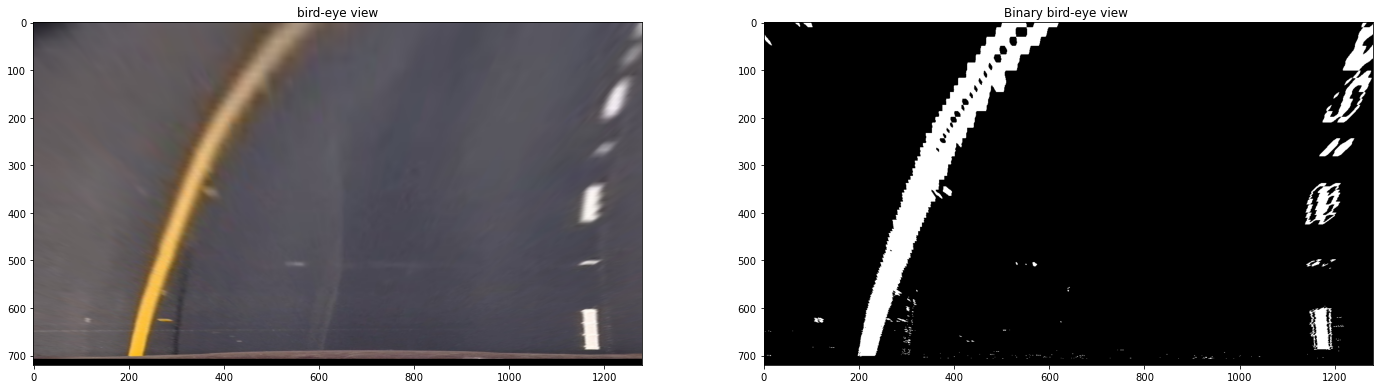

In [31]:
IMAGE_PATH = '../test_images/test3.jpg'
# IMAGE_PATH = '../test_images/straight_lines1.jpg'

TARGET_IMAGE=  mpimg.imread(IMAGE_PATH)

bird_eye_img,bird_eye_img_binary,M_Inv=view_bird_eyes(TARGET_IMAGE,show=True)

In [32]:


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    #  the number of sliding windows
    nwindows = 9
    #  the width of the windows +/- margin
    margin = 80
    #  minimum number of pixels found to recenter window
    minpix = 45

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
#         if window == nwindows-1 : print("window == nwindows-1")
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ###If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)> minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)> minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def lanes_fit_points(left_fit, right_fit, ploty):
    """
    returns the points of the polynomial fit of each lane
    """
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        return left_fitx, right_fitx
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


def fit_polynomial(binary_warped,real=False,show=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx, right_fitx = lanes_fit_points(left_fit, right_fit, ploty)
    if show:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0] #red dots for detected right pixels 
        out_img[righty, rightx] = [0, 0, 255] #blue dots for detected left pixels

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
    if real==True:
#         print("returning real values")
        h = binary_warped.shape[0]
        ym_per_pix = 30/h # meters per pixel in y dimension
        xm_per_pix = 3.7/950 # meters per pixel in x dimension  ---->road width in pixels:  (1200-250)
        left_fit = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)

    return left_fit, right_fit, ploty




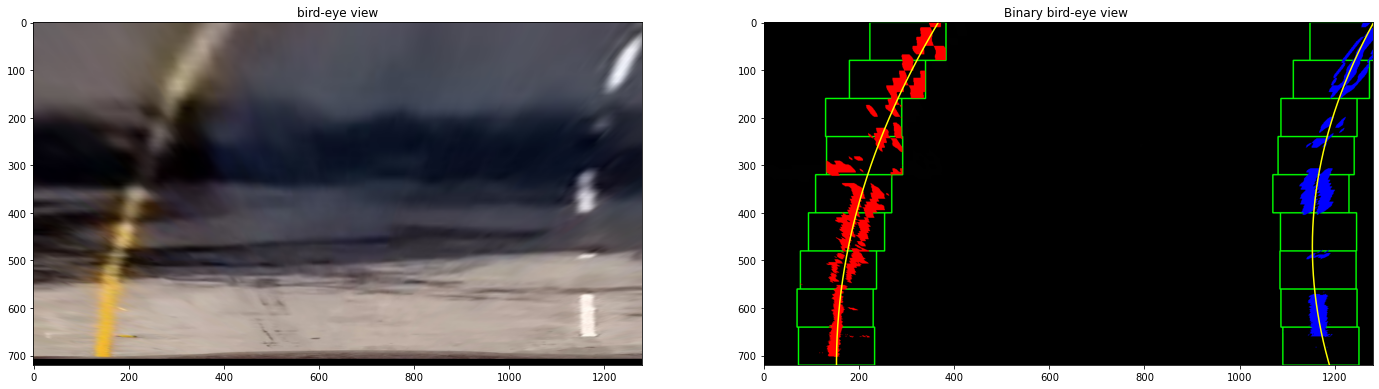

In [33]:

IMAGE_PATH = '../test_images/test5.jpg'
TARGET_IMAGE=  mpimg.imread(IMAGE_PATH)
bird_eye_img,bird_eye_img_binary,M_Inv=view_bird_eyes(TARGET_IMAGE,show=True)
left_fit, right_fit, ploty = fit_polynomial(bird_eye_img_binary,show=True)

In [35]:
   
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    h = binary_warped.shape[0]
    ym_per_pix = 30/h # meters per pixel in y dimension
    xm_per_pix = 3.7/950 # meters per pixel in x dimension ---->road width in pixels:  (1200-250)
    left_fit, right_fit, ploty = fit_polynomial(binary_warped,real=True)
   
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
   
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    curvature = (left_curverad+right_curverad)/2
   
    return left_curverad, right_curverad,curvature
    
def distance_to_center(bird_eye_img_binary):
    """
    Computes the real distance between the car and the center of the road in meters
    """
    left_fit, right_fit, ploty = fit_polynomial(bird_eye_img_binary)
    left_fitx, right_fitx = lanes_fit_points(left_fit, right_fit, ploty)
    #get the height,width of the frame
    w = bird_eye_img_binary.shape[1]
    h = bird_eye_img_binary.shape[0]
    #then we calculate the position of the starting point of each lane
    left_x_start  = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_x_start = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    #then we compute the midpoint between the the two lanes at the
    #bottom of the frame
    lanes_midpoint_x = (left_x_start+right_x_start)//2
    frame_midpoint_x = w//2
    #conversion to meter step
    xm_per_pix = 3.7/950
    #finally return the deviation of the car position
    deviation_from_mid = (frame_midpoint_x - lanes_midpoint_x)* xm_per_pix
    return deviation_from_mid

In [36]:

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad,curvature = measure_curvature_real(bird_eye_img_binary)
deviation = distance_to_center(bird_eye_img_binary)

print("left_curverad: ",left_curverad, 'm '," right_curverad: " ,right_curverad, 'm\n ', f"Central Curvature: {curvature} m ")
print(f"car is deviated {deviation} meters from the center ")

left_curverad:  536.3400631301714 m   right_curverad:  384.77844124016246 m
  Central Curvature: 460.55925218516694 m 
car is deviated -0.1168421052631579 meters from the center 


(720, 1280, 3)


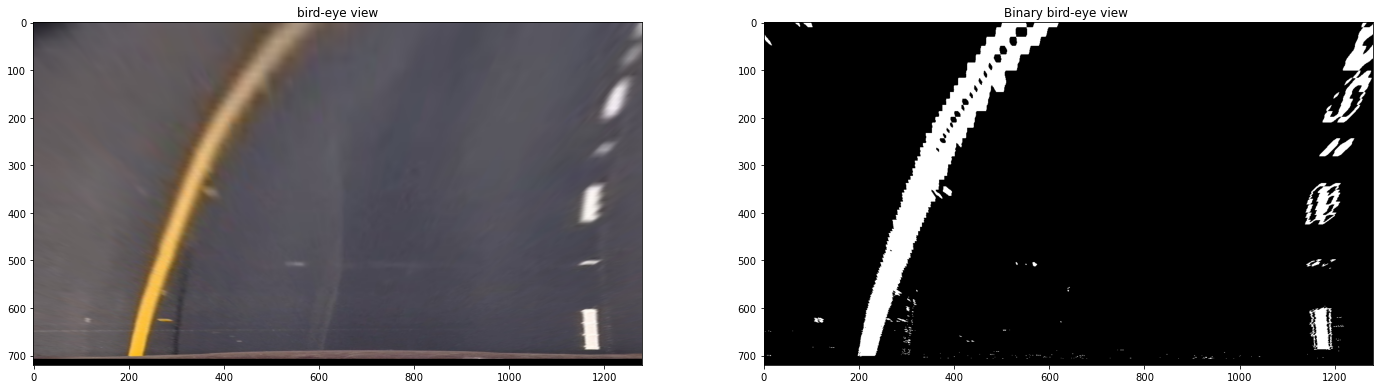

In [41]:
IMAGE_PATH = '../test_images/test3.jpg'
TARGET_IMAGE=  mpimg.imread(IMAGE_PATH)
print(TARGET_IMAGE.shape)
bird_eye_img,bird_eye_img_binary,M_Inv=view_bird_eyes(TARGET_IMAGE,show=True)
# print(bird_eye_img.shape)

In [42]:
def inverse_wrap(img=TARGET_IMAGE,show=False,add_info=True):
    bird_eye_img,bird_eye_img_binary,M_Inv=view_bird_eyes(img)
    left_fit, right_fit, ploty = fit_polynomial(bird_eye_img_binary)
    left_fitx, right_fitx = lanes_fit_points(left_fit, right_fit, ploty)
    #creating a mask image to hold the polygon of the road ROI boundaries 
    channel_template = np.zeros_like(bird_eye_img_binary).astype(np.uint8)
    output_colored = np.dstack((channel_template, channel_template, channel_template))
    left_pts = np.array([np.vstack([left_fitx, ploty]).T])
    right_pts = np.array([np.vstack([right_fitx, ploty]).T[::-1,...]])
    pts = np.hstack((left_pts, right_pts))
    polygon_mask= cv2.fillPoly(output_colored, np.int_([pts]), (155,255, 0))
    inverse_warp = cv2.warpPerspective(polygon_mask, M_Inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    out_image = cv2.addWeighted(img, 1, inverse_warp, 0.5, 0)
    if add_info:
        deviation_text = f"Deviation: {round(distance_to_center(bird_eye_img_binary),2)} m "
        left_curverad, right_curverad,curvature = measure_curvature_real(bird_eye_img_binary)
        Radius_text = f'Road Curve Radius: {round(curvature,2)} m'
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(out_image,deviation_text,(10,50), font, 2,(255,255,255),3)
        cv2.putText(out_image,Radius_text,(10,100), font, 2,(255,255,255), 3)
    if show :
        plt.imshow(out_image)
#         cv2.imwrite("../output_images/annotatedOutput.png",cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB))
    return out_image

(720, 1280, 3)


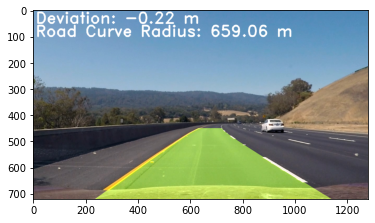

In [43]:
IMAGE_PATH = '../test_images/test3.jpg'
TARGET_IMAGE=  mpimg.imread(IMAGE_PATH)
output = inverse_wrap(img=TARGET_IMAGE,show=True)
print(output.shape)

In [44]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image

def pipeline(frame):
    return inverse_wrap(img=frame)

video_file = VideoFileClip("../project_video.mp4")
output_clip = video_file.fl_image(pipeline) 
%time output_clip.write_videofile(f"project_video_output_final.mp4", audio=False)
    

t:   0%|                                                                    | 2/1260 [00:00<01:44, 12.05it/s, now=None]

Moviepy - Building video project_video_output_final.mp4.
Moviepy - Writing video project_video_output_final.mp4



Moviepy - Done !
Moviepy - video ready project_video_output_final.mp4
Wall time: 3min 29s


In [46]:

HTML("""
<video width="1200" height="700" controls>
  <source src="{0}">
</video>
""".format(f"project_video_output_final.mp4"))

In [ ]:
#apply low pass filter over frames